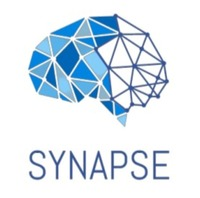

This is a Bonus Hard Tier Task. It is not mandatory to complete the task, but doing this task will give you brownie points in the selection process and learn more into the ever-growing field of ML.

In this notebook we are going to build a simple LSTM model to predict the prices of a stock based on its market history

In [1]:
# Import required Libraries
! pip install yfinance
import pandas as pd
import datetime as dt
from datetime import date
import matplotlib.pyplot as plt
import yfinance as yf
import numpy as np
import tensorflow as tf
import sklearn.preprocessing
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Dense, Dropout, LSTM, Input
from tensorflow.keras.models import Sequential
import keras

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 27.3 MB/s eta 0:00:0000:0100:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.5/73.5 kB 3.7 MB/s eta 0:00:00
  Created wheel for peewee: filename=peewee-3.17.6-cp310-cp310-linux_x86_64.whl size=293632 sha256=2635ddd49b2e3ea7e078db715e229b406e9407fd75cca82a8c2a7408b3520d60
  Stored in directory: /root/.cache/pip/wheels/4b/b9/b0/83d6e258e8f963f5ff111a2cd8c483ca59372a86e6a2535212
Successfully built peewee


2024-08-07 12:03:32.891643: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-07 12:03:32.891777: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-07 12:03:33.057245: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
START = "2010-01-01"
TODAY = date.today().strftime("%Y-%m-%d")

# Function to load the dataset
def load_data(ticker):
    data = yf.download(ticker, START, TODAY)
    data.reset_index(inplace=True)
    return data

In [3]:
data = load_data('TCS.NS') # Load the stock data of Apple since 2010
df=data
df.head()

[*********************100%%**********************]  1 of 1 completed


,Date,Open,High,Low,Close,Adj Close,Volume
0,2010-01-04,377.399994,379.450012,374.524994,375.825012,283.379333,1963682
1,2010-01-05,377.500000,379.774994,373.274994,375.924988,283.454559,2014488
2,2010-01-06,375.924988,376.100006,366.500000,367.424988,277.045441,3349176
3,2010-01-07,367.750000,369.700012,355.500000,357.200012,269.335571,6474892
4,2010-01-08,358.000000,359.250000,348.250000,349.899994,263.831329,6048178


In [4]:
# Since we only need the Close Column so drop all other columns

df = df.drop(columns=["Date","Open","High","Low","Adj Close","Volume"]) # complete this line
df

,Close
0,375.825012
1,375.924988
2,367.424988
3,357.200012
4,349.899994
...,...
3595,4385.350098
3596,4397.100098
3597,4283.049805
3598,4155.049805


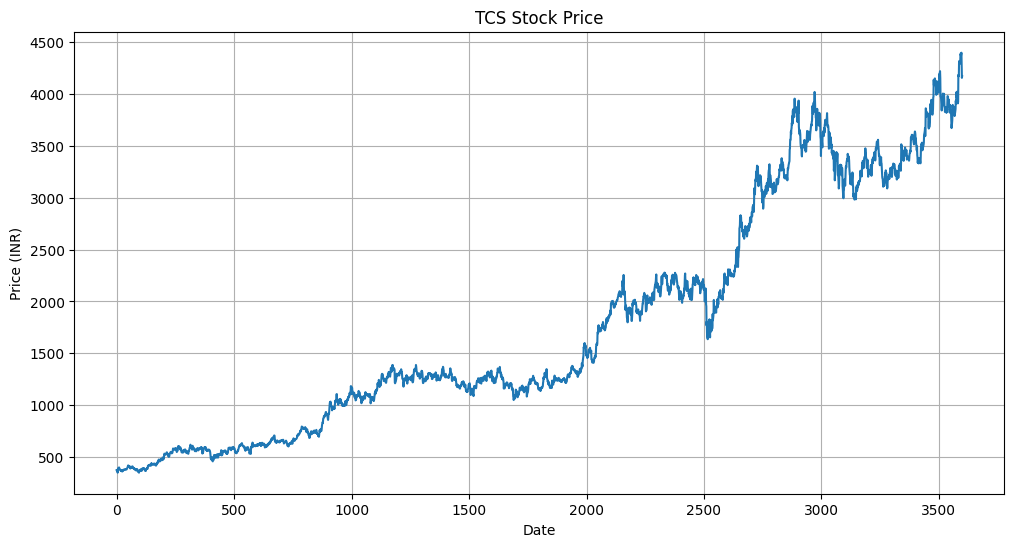

In [5]:
# Plotting the stock price of TCS since 2010
plt.figure(figsize=(12, 6))
plt.plot(df['Close'])
plt.title("TCS Stock Price")
plt.xlabel("Date")
plt.ylabel("Price (INR)")
plt.grid(True)
plt.show()

Now we need to normalize the data in the Dataframe
You can use MinMax Scaler to normalize the data

Resource:
1. https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler

2. https://www.datacamp.com/tutorial/normalization-in-machine-learning

In [6]:
# Normalizaing the values in the Dataframe
#code here
scaler= sklearn.preprocessing.MinMaxScaler(feature_range=(0, 1))
scaled_values = scaler.fit_transform(df)
from sklearn.preprocessing import MinMaxScaler

d = scaler.fit_transform(np.array(df).reshape(-1,1)) 

# this shoud be equal to the scaled values of the DataFrame 
scaled_values= pd.DataFrame(d, columns=['close_new'], index=df.index)
scaled_values

,close_new
0,0.006436
1,0.006461
2,0.004361
3,0.001835
4,0.000031
...,...
3595,0.997097
3596,1.000000
3597,0.971821
3598,0.940195


In [7]:
# Now we split our data into train and test so we can evaluate our model's performance after training
train = scaled_values[:int(scaled_values.shape[0] * 0.70)]
test = scaled_values[int(scaled_values.shape[0] * 0.70):]
#test
#train 

Now we need to modify and train data in such a way that we will be able to feed it into our model

In [8]:
# creating train data such that it can be feeded into the LSTM model, observe why there are 100 inputs 'x' for a single output 'y'
x_train = []
y_train = []
for i in range(100,train.shape[0]):
    x_train.append(train.iloc[i-100:i].values)
    y_train.append(train.iloc[i].values[0])                                
x_train = np.array(x_train)     
y_train = np.array(y_train)
y_train.shape
#x_train.shape
# x_test = []
# for i in range(100,test.shape[0]):
#     x_test.append(test.iloc[i-100:i].values)
# x_test = np.array(x_test)

(2420,)

Now we need to define our model
The Architectue of our model is as follows:

Input layer -> LSTM Layer 1 -> Dropout Layer -> LSTM Layer 2 -> Dropout Layer -> LSTM Layer 3 -> Droput Layer -> LSTM Layer 4 -> Dropout Layer -> Output Layer

Hints:
1. https://keras.io/api/layers/recurrent_layers/lstm/  

2. https://www.kaggle.com/code/kmkarakaya/keras-lstm-explained-in-details
       
3. https://youtu.be/YCzL96nL7j0

In [9]:
# code here
input_layer = Input(shape=(x_train.shape[1], 1),name= 'input_layer')                # external reference 

# Define your model here
model = Sequential()
model.add(Input(shape=(x_train.shape[1], 1),name='input_layer'))
model.add(LSTM(70, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(90, return_sequences=True))
model.add(Dropout(0.2)) 
model.add(LSTM(120, return_sequences=True))
model.add(Dropout(0.2))                                # also referred keras kaggle website in link
model.add(LSTM(140 ))                                  # from website https://medium.com/@zahmed333/stock-price-prediction-with-keras-df87b05e5906
model.add(Dropout(0.2))
model.add(Dense(1))

numberOfLSTMcells = 100
output_layer = LSTM(numberOfLSTMcells, return_sequences=True)(input_layer)# complete this line
#model= keras.Model(inputs=input_layer,outputs=output_layer)
model.summary()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 100, 70)        │        20,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 100, 70)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 100, 90)        │        57,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 100, 90)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 100, 120)       │       101,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 100, 120)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 140)            │       146,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 140)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           141 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 325,701 (1.24 MB)

 Trainable params: 325,701 (1.24 MB)

 Non-trainable params: 0 (0.00 B)

Loss Funtion resources:
1. https://keras.io/api/losses/

2. https://youtu.be/QBbC3Cjsnjg

3. https://machinelearningmastery.com/how-to-choose-loss-functions-when-training-deep-learning-neural-networks/


In [10]:
y_train = y_train.reshape(-1, 1,1)
#print(y_train.shape)
#print(x_train.shape)

model.compile(optimizer='adam',loss='mean_squared_error') # complete this line set the optimized as Adam, and a Loss fucnction you can decide which loss fucntion to use
model.fit(x_train, y_train, epochs = 10) # fill in the x_train,x_test data along with the number of epochs

Epoch 1/10
76/76 ━━━━━━━━━━━━━━━━━━━━ 24s 243ms/step - loss: 0.0086
Epoch 2/10
76/76 ━━━━━━━━━━━━━━━━━━━━ 19s 248ms/step - loss: 4.6501e-04
Epoch 3/10
76/76 ━━━━━━━━━━━━━━━━━━━━ 19s 245ms/step - loss: 5.1674e-04
Epoch 4/10
76/76 ━━━━━━━━━━━━━━━━━━━━ 19s 249ms/step - loss: 6.2117e-04
Epoch 5/10
76/76 ━━━━━━━━━━━━━━━━━━━━ 20s 248ms/step - loss: 4.8924e-04
Epoch 6/10
76/76 ━━━━━━━━━━━━━━━━━━━━ 19s 245ms/step - loss: 3.8428e-04
Epoch 7/10
76/76 ━━━━━━━━━━━━━━━━━━━━ 19s 249ms/step - loss: 4.1624e-04
Epoch 8/10
76/76 ━━━━━━━━━━━━━━━━━━━━ 19s 247ms/step - loss: 4.2023e-04
Epoch 9/10
76/76 ━━━━━━━━━━━━━━━━━━━━ 21s 250ms/step - loss: 4.6603e-04
Epoch 10/10
76/76 ━━━━━━━━━━━━━━━━━━━━ 20s 250ms/step - loss: 3.2609e-04


To predict the data from out LSTM model we need last 100 sequences from our training data to predict the 1st value in the Test data, create a new array which contains last 100 values of the training data and all of the values of the testing data

In [11]:
testing_input_model = scaled_values[int(scaled_values.shape[0] * 0.70):]
testing_input_model = scaler.fit_transform(testing_input_model)
print(testing_input_model.shape)

testing_model = []
for i in range(100, len(testing_input_model)):             #inspired from https://medium.com/@zahmed333/stock-price-prediction-with-keras-df87b05e5906             
  testing_model.append(testing_input_model[i-100:i])       #external reference
testing_model = np.array(testing_model)                           
testing_model = np.reshape(testing_model, (testing_model.shape[0], testing_model.shape[1], 1))
#print(testing_model.shape)
predict_model = model.predict(testing_model)
#print(predict_model.shape)

predict_model = predict_model.reshape(-1, predict_model.shape[1])
#print(predict_model.shape)

to_predict = scaler.inverse_transform(predict_model) # code here

(1080, 1)
31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 111ms/step


Just as we did for the training data, convert the testing data into a format such that we can feed it into out LSTM model to get predictions

In [12]:
x_test = []
y_test = []
for i in range(100,test.shape[0]):
    x_test.append(test.iloc[i-100:i].values)
    y_test.append(test.iloc[i].values[0])                                
x_test = np.array(x_test)     
y_test = np.array(y_test)
#y_test.shape
#x_test.shape
# code here


In [13]:
y_pred = model.predict(x_test)

31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 92ms/step


Now we have the predicted values of out test data, but if you notice one thing, the data is between 0-1 because we had normalised the data before, now we need to scale the data back up to its orignal values

In [15]:
# complete both the lines below, y_test and y_pred should be equal to the scaled-up values
y_test = scaler.inverse_transform(pd.DataFrame(y_test))
y_pred = scaler.inverse_transform(pd.DataFrame(y_pred))

Plotting the Orignal and the Precited price by our model

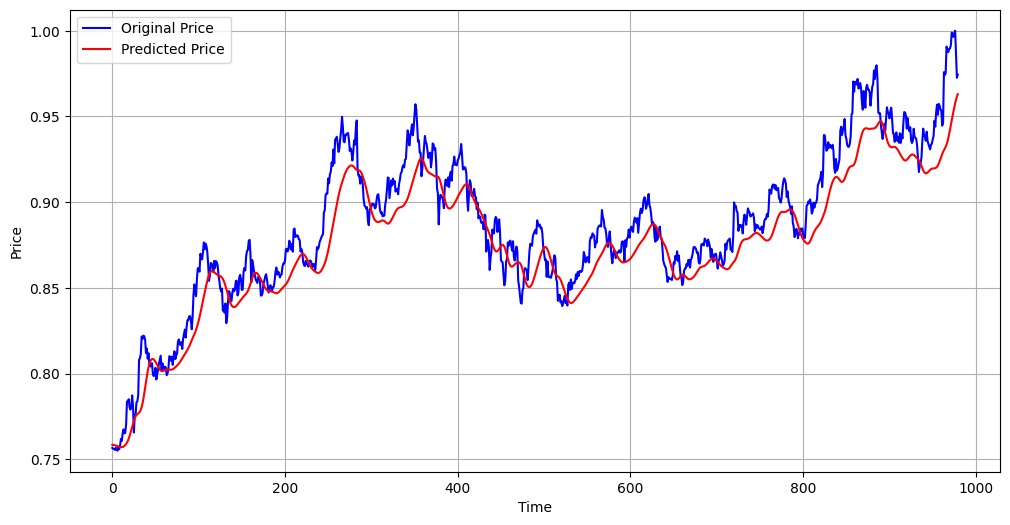

In [16]:
plt.figure(figsize = (12,6))
plt.plot(y_test, 'b', label = "Original Price")
plt.plot(y_pred, 'r', label = "Predicted Price")
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

Your graph should look like this, if not try changing the parameters of you LSTM model

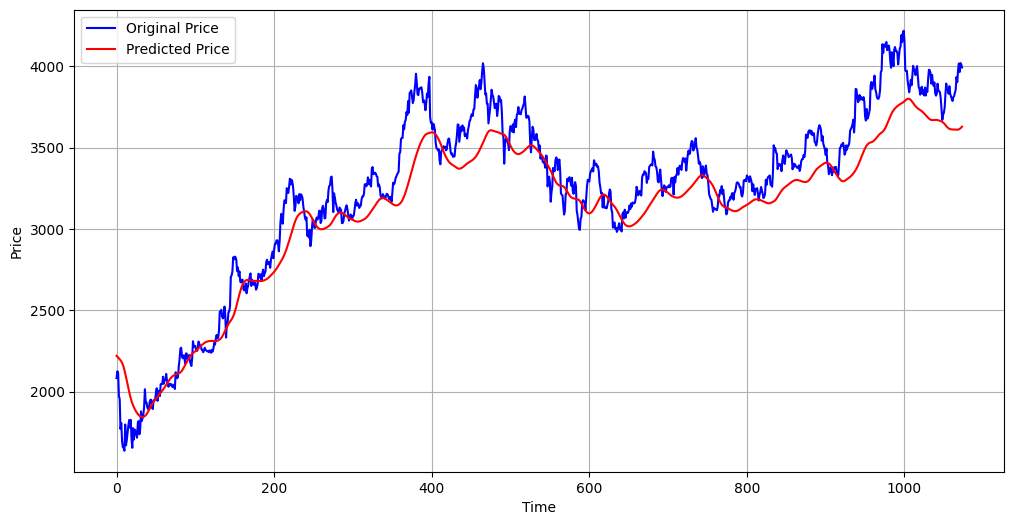

As you can see above our model was fairly able to precit the value of the stock, but how do we quantify how good the predictions are, this is where model evaluation comes into the picture.

In [17]:
# Calculate the Mean Absolute Error of our model

# code here
import math                               # reference : https://www.linkedin.com/pulse/how-develop-stock-price-prediction-model-beginners-guide-daniel-kwnlf
from sklearn import metrics 
print('Mean Absolute Error (MAE)')
mav = metrics.mean_absolute_error(y_test, y_pred)
print('MAE Value:' ,mav)

Mean Absolute Error (MAE)
MAE Value: 0.014053568301948264


In [18]:
#complete the lines below to calculate the R2 Score of our model

from sklearn.metrics import r2_score
# reference : https://www.linkedin.com/pulse/how-develop-stock-price-prediction-model-beginners-guide-daniel-kwnlf
actual = y_test.tolist()

predicted = y_pred.tolist()

r2 = r2_score(actual, predicted) 

print("R2 score:", r2)

R2 score: 0.8452697762820098


Plotting the R2 Score

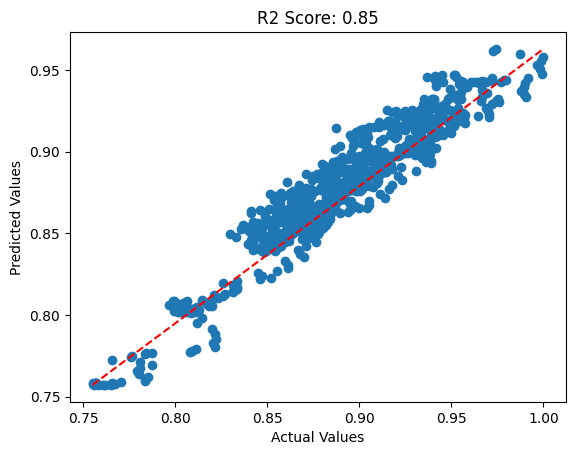

In [19]:
plt.scatter(actual, predicted)
#plt.plot([min(actual), max(actual)], [min(predicted), max(predicted)], 'r--')
plt.plot([min(actual), max(actual)], [min(predicted), max(predicted)], 'r--')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title(f'R2 Score: {r2:.2f}')
plt.show()

Your Graph should look like this

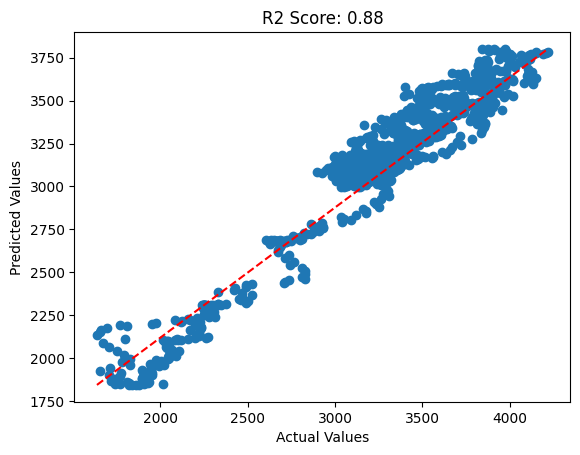

For any doubts contact:

Atharv Mendhe: +918454993809

Hirali Sangani: +919167574134